<a href="https://colab.research.google.com/github/gis-up-shim/test/blob/main/RSdata_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning RS data

[I. Weekend Data with Heavy Users](#first-bullet)  
[II. Data Aggregation](#second-bullet)

In [ ]:
import pickle
import gzip
import base64
import datetime as dt
import json
import os
import struct
import time
import csv
import math
import numpy as np
import pandas as pd
import itertools
import urllib

from tqdm.notebook import tqdm

from io import BytesIO
from datetime import datetime
# from pyproj import Proj, transform
from scipy.sparse import csr_matrix
from collections import namedtuple
import scipy.sparse as sp

import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', None)

# I. Weekend Data with Heavy Users <a class="anchor" id="first-bullet"></a>

**Weekend/holiday data (27days)**:
0727,0728,0803,0804,0810,0811,0817,0818,0824,0825,0831,0901,0907,0908,0914,0915,0921,0922,0928,0929,10051006,1012,1013,1014(holiday),1019,1020

In [ ]:
# list of weekend date

weekend_date = ["0727","0728","0803","0804","0810","0811","0817","0818","0824","0825","0831","0901","0907","0908",
                "0921","0922","0928","0929","1005","1006","1012","1013","1019","1020"]
print('# weekend dates:', len(weekend_date))

# weekend dates: 24


In [ ]:
# save userName of each trip in the empty list

userName_lst = []

for i in tqdm(weekend_date):
    with open('/project/kakao/rs_merged_2019'+i+'.pickle','rb') as f:
        data = pickle.load(f)
    for trip in data.keys():
        try:
            userName_lst.append(data[trip][list(data[trip].keys())[0]]['userName'])
        except:
            pass

FileNotFoundError: ignored

In [ ]:
# count each drivers' number of trips

from collections import Counter
weekend_trip_per_driver = Counter(userName_lst)

In [ ]:
# the number of drivers of weekend data

len(weekend_trip_per_driver.keys())

615051

In [ ]:
# Top 10 values from driver counter

weekend_trip_per_driver.most_common(10)

[('YgEdWWRbQaqWAWDfvSVhe6yXhAVsfZkOgMbj-Jbn-Ls', 558),
 ('0SW29Y1YlcSrU5WH6y2Uwe-Arm5DaWZIdSQJC_uvIYc', 464),
 ('l1edH2_9-qj5-we8GRAwIoRwB6wP6nICgc6D9pTLHyQ', 423),
 ('1iiu89sqRCkG_tB9uLQjmInZI1CXFv8Zqx6yYMpJf6k', 359),
 ('cA0UeXWfUlYo1Dcb85afiBAKajtJRfkegTe52UzqxFY', 349),
 ('H9YYB5QPzFMz6DwlK8Xj5INjChv_djgSC0IvVfx0QXo', 343),
 ('RmmLFF-6OyoME2UNBienK5d5EjUAy-TgqccqzF3wvnA', 336),
 ('N1mCkVpt43PUqmzO1Jbpa1umWmF3yA1-KYp62oOteXg', 332),
 ('ObsaWW5QlefROoYUnDivALUniiLouh2L4D2KS8-omH0', 332),
 ('7w1rQxWjUKilUT12QKCoycwo9x3VlmRXhssmiaH_w-A', 325)]

In [ ]:
c = weekend_trip_per_driver.copy()

In [ ]:
# convert Counter into DataFrame

counter_df = pd.DataFrame.from_dict(weekend_trip_per_driver, orient='index').reset_index().rename(columns={'index':'userName', 0:'num_trip'})
counter_df.head(5)

In [ ]:
# userName of heavy users

heavy_user_counter = Counter({k: c for k, c in c.items() if c >= 30}) # heavy users: drivers who have more or equal to 30 trips
heavy_counter_df = pd.DataFrame.from_dict(heavy_user_counter, orient='index').reset_index().rename(columns={'index':'userName', 0:'num_trip'})
heavy_counter_df.head(5)

,userName,num_trip
0,WSNA_q8NwW7xjX5iOzLGy7ID_mwmZY2HNOoRK0wksNk,39
1,EscOJ2w6Ao5UK0BRZ0Vaco8jATTzJnOcdLPXDlhfLMY,55
2,7-ZMS4MglSKXK7FnmyxaPW96wOC7vOcTEz8zpfuEHiQ,68
3,7Z_2p1x7e3tyTgqDCqMdGRJJAEEf_yko4mUJEQAsnGM,78
4,CS82Z6MvliUw3FkVzFuD1Pejh5HVqL7uJHcmSfz_9O4,112


In [ ]:
# save heavy user information
heavy_counter_df.to_csv('/project/kakao/heavy_counter30_df.csv')

In [ ]:
print('# of entire drivers: ',len(weekend_trip_per_driver.keys()))
print('# of heavy drivers: ',len(heavy_user_counter.keys()))

# of entire drivers:  615051
# of heavy drivers:  2054


In [ ]:
# # sorting counter
# sorted(c.items(), key=lambda pair: pair[1], reverse=False)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level

<AxesSubplot:ylabel='Density'>

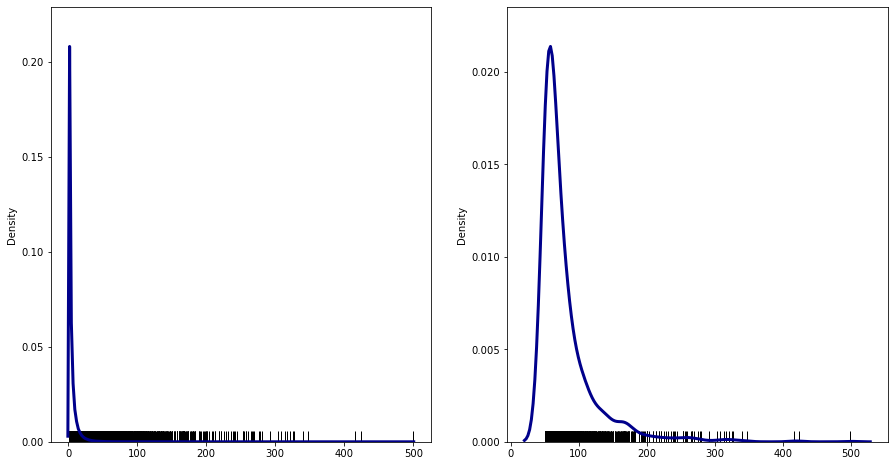

In [ ]:
# plotting trip density

# for entire weekend drivers
fig, axs = plt.subplots(ncols=2, figsize = (15,8))
sns.distplot(list(counter_df.num_trip), hist = False, kde = True, rug = True,
             color = 'darkblue',
             kde_kws={'linewidth': 3},
             rug_kws={'color': 'black'}, ax=axs[0])

# for heavy users (drivers)
sns.distplot(list(heavy_counter_df.num_trip), hist = False, kde = True, rug = True,
             color = 'darkblue',
             kde_kws={'linewidth': 3},
             rug_kws={'color': 'black'}, ax=axs[1])


# II. Data Aggregation <a class="anchor" id="second-bullet"></a>

1. **UniqueLinkID**  
    a. Magnitude
        - FacilityType (-1,0,1)
        - RoadType (3,2,1,0,-1)
     b. Weighted Average
         - laneCount
        - currentSpeed
        - speedlimit
2. **SafetyRgs**

## 1. UniqueLinkID

### Magnitude  
- FacilityType
- RoadType

In [ ]:
# assign magnitude to roade type and facility type

def assign_magnitude(data):
    for trip in data:
        for route in data[trip]:
            #list of dictionary
            try:
                for d in data[trip][route]['routeLinks']:
                    #roadType
                    if d['roadType'] == 0 or d['roadType'] == 1:
                        d['roadType'] = 3
                    elif d['roadType'] == 2 or d['roadType'] == 3 or d['roadType'] == 4:
                        d['roadType'] = 2
                    elif d['roadType'] == 5 or d['roadType'] == 6 or d['roadType'] == 7:
                        d['roadType'] = 1
                    elif d['roadType'] == 8:
                        d['roadType'] = 0
                    else:
                        d['roadType'] = -1

                    #facilityType
                    if d['facilityType'] == 0 or d['facilityType']==1 or d['facilityType']==2:
                        d['facilityType'] = 0
                    else:
                        d['facilityType'] = 1
    #             data[trip][route]['roadType'] = sum(ele['roadType']*ele['length'] for ele in data[trip][route]['routeLinks'])/sum(ele['length'] for ele in data[trip][route]['routeLinks'])
                data[trip][route]['roadType'] = sum(ele['roadType'] for ele in data[trip][route]['routeLinks'])
                data[trip][route]['facilityType'] = sum(ele['facilityType'] for ele in data[trip][route]['routeLinks'])


            except:
                pass

### Weighted Average
- laneCount
- limitSpeed
- currentTrafficSpeed

In [ ]:
# calculate weighted average for land/count, limitSpeed, and currentTrafficSpeed

def weighted_avg(data):
    for trip in data.keys():
        for route in data[trip].keys():
            try:
                data[trip][route]['laneCount'] = sum(ele['laneCount']*ele['length'] for ele in data[trip][route]['routeLinks'])/sum(ele['length'] for ele in data[trip][route]['routeLinks'])
                data[trip][route]['limitSpeed'] = sum(ele['limitSpeed']*ele['length'] for ele in data[trip][route]['routeLinks'])/sum(ele['length'] for ele in data[trip][route]['routeLinks'])
                data[trip][route]['currentTrafficSpeed'] = sum(ele['currentTrafficSpeed']*ele['length'] for ele in data[trip][route]['routeLinks'])/sum(ele['length'] for ele in data[trip][route]['routeLinks'])
            except:
                data[trip][route]['laneCount'] = 'NaN'
                data[trip][route]['limitSpeed'] = 'NaN'
                data[trip][route]['currentTrafficSpeed'] = 'NaN'

## 2. SafetyRgs

In [ ]:
# sum safetycount (The number of Saftey data in the trip; 경로에 포함되어 있는 안전운행 데이터 개수)

def safetyRgs(data):
    for trip in data.keys():
        for route in data[trip].keys():
            try:
                if len(data[trip][route]['safetyRgs']) == 0:
                    data[trip][route]['safetyCount'] = 'NaN'
                else:
                    for d in data[trip][route]['safetyRgs']:
                        data[trip][route]['safetyCount'] = sum(ele['safetyCount'] for ele in data[trip][route]['safetyRgs'])
            except:

                data[trip][route]['safetyCount'] = 'NaN'


In [ ]:
# Assign magnitude to safetycode

def safetyCode(data):
    nega_code = [80,83,87,88,94,95,98,99,101] # for these codes, assign -1 (negatively affect selecting the route)
    neut_code = [15,20] # for these codes, assign 0 (netural)
    posi_code = [1] # for these codes, assign +1 (positively affect selecting the route)
#     safety_code = 0
    for trip in data:
        for route in data[trip]:
            safety_code = 0
            try:
                if len(data[trip][route]['safetyRgs']) == 0:
                    data[trip][route]['safetyCode'] = 'NaN'

                else:
                    for d in data[trip][route]['safetyRgs']:
                        for info in d['safetyRgs']:
                            if info['safetyCode'] in nega_code:
                                info['safetyCode'] = 0
                            elif info['safetyCode'] in neut_code:
                                info['safetyCode'] = 1
                            else:
                                info['safetyCode'] = -1

                            safety_code += info['safetyCode']
                    data[trip][route]['safetyCode'] = safety_code
            except:
                data[trip][route]['safetyCode'] = 'NaN'


In [ ]:
# removing unrelated/unnecessary features from dictionary

def cleaning_dict(data):
    del_list = ['time','routeLinks', 'safetyRgs', 'car_type', 's_x', 's_y', 'e_x', 'e_y']
    for trip in data.keys():
        for route in data[trip].keys():
            for key in list(data[trip][route].keys()):
                if key in del_list:
                    del data[trip][route][key]

In [ ]:
def aggregated_preprocess(data):
    weighted_avg(data)
    safetyRgs(data)
    safetyCode(data)
    cleaning_dict(data)

In [ ]:
safetyRgs(data)

In [ ]:
safetyCode(data)

In [ ]:
cleaning_dict(data)

In [ ]:
colnames = list(data['000058bfe6e54df8b37e66d1a3c9d246']['000058bfe6e54df8b37e66d1a3c9d246-50000'].keys())

In [ ]:
# read heavy user list to preprocess
heavy_user_df = pd.read_csv('/project/kakao/heavy_counter50_df.csv', index_col = [0])
heavy_user_df.head()

,userName,num_trip
0,EscOJ2w6Ao5UK0BRZ0Vaco8jATTzJnOcdLPXDlhfLMY,55
1,7-ZMS4MglSKXK7FnmyxaPW96wOC7vOcTEz8zpfuEHiQ,68
2,7Z_2p1x7e3tyTgqDCqMdGRJJAEEf_yko4mUJEQAsnGM,78
3,CS82Z6MvliUw3FkVzFuD1Pejh5HVqL7uJHcmSfz_9O4,112
4,A73vKodeN7w04pzOcoqpBv9PwNZ-xzTqhuyzsVga4bc,322


In [ ]:
# list of heavy users
heavy_user_list = list(heavy_user_df.userName)

In [ ]:
len(heavy_user_list)

2054

In [ ]:
df_lst = []

for i in tqdm(weekend_date):
    with open('/project/kakao/rs_merged_2019'+i+'.pickle','rb') as f:
        data = pickle.load(f)
        assign_magnitude(data)
        weighted_avg(data)
        safetyRgs(data)
        safetyCode(data)
        cleaning_dict(data)
    for trip in data.keys():
        try:
            if data[trip][list(data[trip].keys())[0]]['userName'] in heavy_user_list:
                d = data[trip]
                df = pd.concat([pd.DataFrame.from_dict([d[list(d.keys())[0]]],orient = 'columns'),pd.DataFrame.from_dict([d[list(d.keys())[1]]],orient = 'columns')],axis = 1)
                df_lst.append(df)
                df.to_csv('/project/kakao/preprocessed_data/heavy_user_weekend_df.csv', mode='a', header=False)

        except:
            pass




In [ ]:
colnames = ['forecast_time','distance','fare','s_hcode','e_hcode','default','selected','userName','requestTime','routePointCount',
           'routeDistance','routeTravelTime','routeLinkCount','rgCount','safeyRgCount','roadType','facilityType','laneCount','limitSpeed',
           'currentTrafficSpeed','safetyCount','safetyCode']


In [ ]:
df = pd.read_csv('/project/kakao/preprocessed_data/heavy_user_weekend_df.csv', skiprows = 1, header=None)
# Drop first column of dataframe
df = df.iloc[: , 1:]
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,2092,27125,0,5011065000,5013031000,0.0,1.0,7-ZMS4MglSKXK7FnmyxaPW96wOC7vOcTEz8zpfuEHiQ,2019-07-27T08:52:06.522,396,27125,2092,148,7,24,274,0,4.154728,72.950046,61.665806,30.0,-28.0,2108,27125,0,5011065000,5013031000,1.0,0.0,7-ZMS4MglSKXK7FnmyxaPW96wOC7vOcTEz8zpfuEHiQ,2019-07-27T09:18:43.405,73.0,3209.0,281.0,22.0,5.0,7.0,28.0,0.0,1.852602,46.880648,44.483017,10.0,-10.0
1,5129,63620,0,5011025300,5013025900,0.0,1.0,7Z_2p1x7e3tyTgqDCqMdGRJJAEEf_yko4mUJEQAsnGM,2019-07-27T12:49:05.372,251,12805,1266,84,9,17,132,0,2.622882,59.161265,42.696369,20.0,-19.0,5172,64381,0,5011025300,5013025900,1.0,0.0,7Z_2p1x7e3tyTgqDCqMdGRJJAEEf_yko4mUJEQAsnGM,2019-07-27T12:49:05.374,247.0,13021.0,1224.0,81.0,8.0,15.0,127.0,0.0,2.604562,58.990093,43.063897,18.0,-18.0
2,188,1159,0,4113559000,4113551000,0.0,1.0,CS82Z6MvliUw3FkVzFuD1Pejh5HVqL7uJHcmSfz_9O4,2019-07-27T12:59:57.027,36,1159,188,11,5,0,9,0,3.845557,58.878343,38.415013,NaN,NaN,188,1159,0,4113559000,4113551000,1.0,0.0,CS82Z6MvliUw3FkVzFuD1Pejh5HVqL7uJHcmSfz_9O4,2019-07-27T12:59:57.027,36.0,1159.0,188.0,11.0,5.0,0.0,9.0,0.0,3.845557,58.878343,38.415013,NaN,NaN
3,846,3513,0,2726058000,2726062000,0.0,1.0,A73vKodeN7w04pzOcoqpBv9PwNZ-xzTqhuyzsVga4bc,2019-07-27T18:12:45.224,104,3513,846,52,4,4,52,0,7.015087,57.275833,21.165955,4.0,-4.0,911,5676,0,2726058000,2726062000,1.0,0.0,A73vKodeN7w04pzOcoqpBv9PwNZ-xzTqhuyzsVga4bc,2019-07-27T18:12:45.221,171.0,5676.0,911.0,54.0,12.0,3.0,98.0,5.0,3.127731,70.433404,34.420014,3.0,-3.0
4,659,6650,0,5013031000,5013025000,0.0,1.0,KA1zrTUh7JsDSYG9iYSqFEDwNZ_4LOMgxwbOxgkueBY,2019-07-27T14:30:21.141,256,9655,970,86,11,15,127,0,2.546142,55.113413,45.919420,18.0,-17.0,659,6650,0,5013031000,5013025000,1.0,0.0,KA1zrTUh7JsDSYG9iYSqFEDwNZ_4LOMgxwbOxgkueBY,2019-07-27T14:30:21.142,256.0,9655.0,970.0,86.0,11.0,15.0,127.0,0.0,2.546142,55.113413,45.919420,18.0,-17.0


In [ ]:
df.columns = colnames + colnames
df.head()

,forecast_time,distance,fare,s_hcode,e_hcode,default,selected,userName,requestTime,routePointCount,routeDistance,routeTravelTime,routeLinkCount,rgCount,safeyRgCount,roadType,facilityType,laneCount,limitSpeed,currentTrafficSpeed,safetyCount,safetyCode,forecast_time,distance,fare,s_hcode,e_hcode,default,selected,userName,requestTime,routePointCount,routeDistance,routeTravelTime,routeLinkCount,rgCount,safeyRgCount,roadType,facilityType,laneCount,limitSpeed,currentTrafficSpeed,safetyCount,safetyCode
0,2092,27125,0,5011065000,5013031000,0.0,1.0,7-ZMS4MglSKXK7FnmyxaPW96wOC7vOcTEz8zpfuEHiQ,2019-07-27T08:52:06.522,396,27125,2092,148,7,24,274,0,4.154728,72.950046,61.665806,30.0,-28.0,2108,27125,0,5011065000,5013031000,1.0,0.0,7-ZMS4MglSKXK7FnmyxaPW96wOC7vOcTEz8zpfuEHiQ,2019-07-27T09:18:43.405,73.0,3209.0,281.0,22.0,5.0,7.0,28.0,0.0,1.852602,46.880648,44.483017,10.0,-10.0
1,5129,63620,0,5011025300,5013025900,0.0,1.0,7Z_2p1x7e3tyTgqDCqMdGRJJAEEf_yko4mUJEQAsnGM,2019-07-27T12:49:05.372,251,12805,1266,84,9,17,132,0,2.622882,59.161265,42.696369,20.0,-19.0,5172,64381,0,5011025300,5013025900,1.0,0.0,7Z_2p1x7e3tyTgqDCqMdGRJJAEEf_yko4mUJEQAsnGM,2019-07-27T12:49:05.374,247.0,13021.0,1224.0,81.0,8.0,15.0,127.0,0.0,2.604562,58.990093,43.063897,18.0,-18.0
2,188,1159,0,4113559000,4113551000,0.0,1.0,CS82Z6MvliUw3FkVzFuD1Pejh5HVqL7uJHcmSfz_9O4,2019-07-27T12:59:57.027,36,1159,188,11,5,0,9,0,3.845557,58.878343,38.415013,NaN,NaN,188,1159,0,4113559000,4113551000,1.0,0.0,CS82Z6MvliUw3FkVzFuD1Pejh5HVqL7uJHcmSfz_9O4,2019-07-27T12:59:57.027,36.0,1159.0,188.0,11.0,5.0,0.0,9.0,0.0,3.845557,58.878343,38.415013,NaN,NaN
3,846,3513,0,2726058000,2726062000,0.0,1.0,A73vKodeN7w04pzOcoqpBv9PwNZ-xzTqhuyzsVga4bc,2019-07-27T18:12:45.224,104,3513,846,52,4,4,52,0,7.015087,57.275833,21.165955,4.0,-4.0,911,5676,0,2726058000,2726062000,1.0,0.0,A73vKodeN7w04pzOcoqpBv9PwNZ-xzTqhuyzsVga4bc,2019-07-27T18:12:45.221,171.0,5676.0,911.0,54.0,12.0,3.0,98.0,5.0,3.127731,70.433404,34.420014,3.0,-3.0
4,659,6650,0,5013031000,5013025000,0.0,1.0,KA1zrTUh7JsDSYG9iYSqFEDwNZ_4LOMgxwbOxgkueBY,2019-07-27T14:30:21.141,256,9655,970,86,11,15,127,0,2.546142,55.113413,45.919420,18.0,-17.0,659,6650,0,5013031000,5013025000,1.0,0.0,KA1zrTUh7JsDSYG9iYSqFEDwNZ_4LOMgxwbOxgkueBY,2019-07-27T14:30:21.142,256.0,9655.0,970.0,86.0,11.0,15.0,127.0,0.0,2.546142,55.113413,45.919420,18.0,-17.0
